<center> <font size = 6> Machine Learning II - Classification Project </font> </center>
<br> 
<center> <font size = 4> Image Classification for Malaria Detection </font> </center>
<br>
<font size = 4> Prepared by: <b> Maciej Wysocki </b> </font>

The dataset consits of images of blood cells - some of them are infected with malaria, while the others are healthy ones. The goal of this project is to come up with a Convolutional Neural Network model that will be able to correctly classify the healthy and infected cells based on their image. In order to achieve that, several variations of CNNs are compared along with using different methods of data augmentation and tuning. 

<br>

## Load libraries and modules

In [1]:
import os
path = os.path.dirname(os.getcwd())
os.chdir(path)

import logging
logging.getLogger('tensorflow').disabled = True

import pickle

In [2]:
import pandas as pd 
import numpy as np

from IPython.display import display

In [3]:
import tensorflow as tf
print(tf.test.is_gpu_available()) # Make sure tensorflow detects GPU
print(tf.test.gpu_device_name()) # "name" of the GPU device

True
/device:GPU:0


In [4]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model

In [6]:
from modelling.data_reader import ImageDataReader # custom class for loading and handling imagees

from modelling.cnn_models import TwoLayers, ThreeLayers, LeNet5, AlexNet
from modelling.transfer_models import VGG19, ResNet50, MobileNetV2 

In [7]:
from visualization.plotters import ImageDataShow, VisualizePerformance

In [8]:
img_show = ImageDataShow()
plot_perf = VisualizePerformance()

<center> <font size=6> <b> Data </b> </font> </center>

Below one dataset is loaded in two ways - one is the standard set of images and the second one cotains augmented images, that is images that were introduced to different modifications such as zooming or shifting.

## Load data

In [9]:
data_handler = ImageDataReader(path='data', 
                               rescale=1.0/255, 
                               target_size=(115, 115),
                               batch_size=128, 
                               validation_split=0.2)

train = data_handler.get_train_data()
validation = data_handler.get_validation_data()

Found 21466 images belonging to 2 classes.
Found 5366 images belonging to 2 classes.


In [9]:
augmented_data_handler = ImageDataReader(path='data', 
                                         rescale=1.0/255, 
                                         target_size=(115, 115),
                                         batch_size=128, 
                                         validation_split=0.2, 
                                         rotation_range=20, 
                                         zoom_range=0.15, 
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.15, 
                                         horizontal_flip=True, 
                                         fill_mode="nearest")

aug_train = augmented_data_handler.get_train_data()
aug_validation = augmented_data_handler.get_validation_data()

Found 21466 images belonging to 2 classes.
Found 5366 images belonging to 2 classes.


In [105]:
test_data_handler = ImageDataReader(path='testing_data', 
                                    rescale=1.0/255, 
                                    target_size=(115, 115),
                                    validation_split=0.0)

test = test_data_handler.get_train_data()

Found 726 images belonging to 2 classes.


## Quick glimpse at images 

Before modelling, let's check how the images look like in order to get a sense of what will actually be modelled.

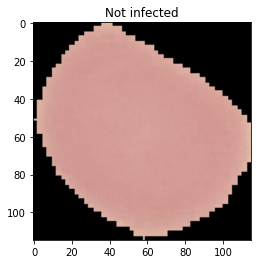

Shape: (115, 115, 3)
Batch size: 128
Color mode: rgb
Class mode: binary
Classes: [0 0 0 ... 1 1 1]


In [10]:
# Display a sample image from the training set
img_show.show_image(train[1][0][0], train[1][1][0])

# Print information about the data
print(f'Shape: {train[1][0][0].shape}')
print(f'Batch size: {train.batch_size}')
print(f'Color mode: {train.color_mode}')
print(f'Class mode: {train.class_mode}')
print(f'Classes: {train.classes}')

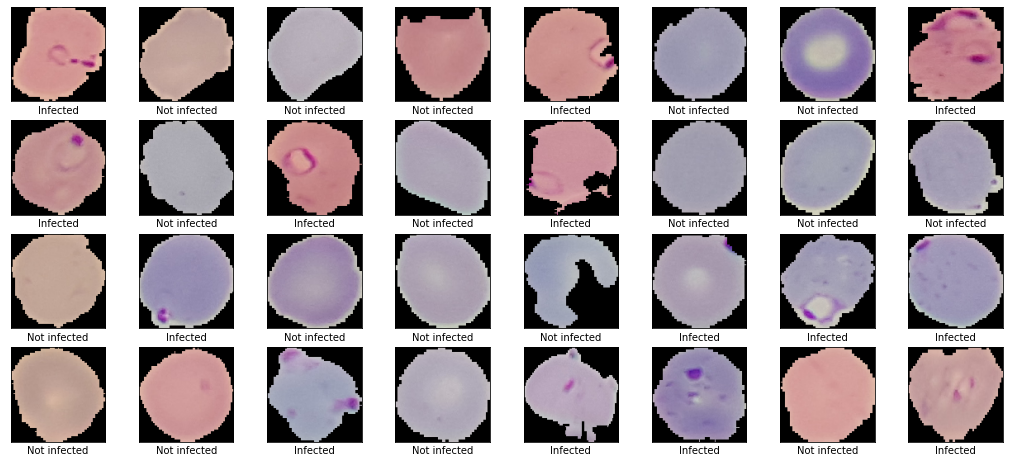

In [11]:
# Display a batch of 32 images
img_show.show_batch(train[0][0], train[0][1])

<br>

### Augmented Images

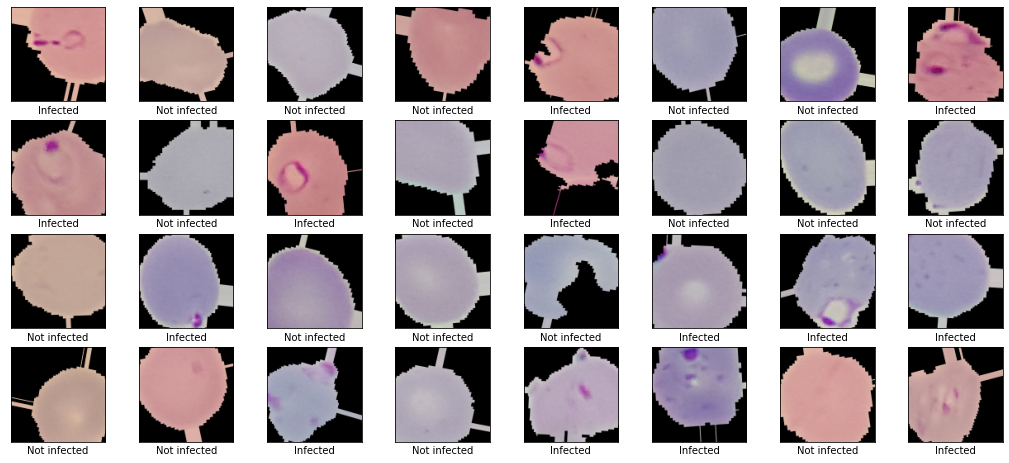

In [10]:
# Display a batch of 32 images
img_show.show_batch(aug_train[0][0], aug_train[0][1])

As clearly visible, applying augmentation techniques changed the images significantly.

<center> <font size=6> <b> Convolutional Neural Networks </b> </font> </center>

Machine learning models that will be used for image classification in this project are convoltuional neural networks. At the very beginning, there are some simple architectures used, then several popular architectures are implemented and checked. That part is followed by trasfer learning, which takes advantage of neural networks pre-trained on  large datasets that can be than trained further and used for classyfing another images.

## Two Layers CNN

The very first model is a simple CNN consisting of two layers, it's architecture is presented below.

In [10]:
two_layers_cnn = TwoLayers(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
two_layers_cnn.get_summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 115, 115, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 115, 115, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        9280      
_________________________________________________________________
activation_1 (Activation)    (None, 57, 57, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)            

In most cases Adam optimizer will be used for training of the CNNs. The loss function is binary crossentropy, which is a typical choice in such applications. Additionally accuraccy of classifications will be reported. 

In [10]:
optimizer = Adam(lr=0.001) # Adaptive Moment Estimation optimizer
two_layers_cnn.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # compile the model

In [ ]:
history_two_layers = two_layers_cnn.train(training_data=train, epochs=25, validation_data=validation)

In [10]:
scores_train = two_layers_cnn.evaluate(train)
scores_val = two_layers_cnn.evaluate(validation)

42/42 [==============================] - 6s 139ms/step - loss: 0.4255 - accuracy: 0.9266


In [11]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.0022
Training Accuracy: 99.95%
Validation Binary Crossentropy (Loss): 0.4255
Validation Accuracy: 92.66%


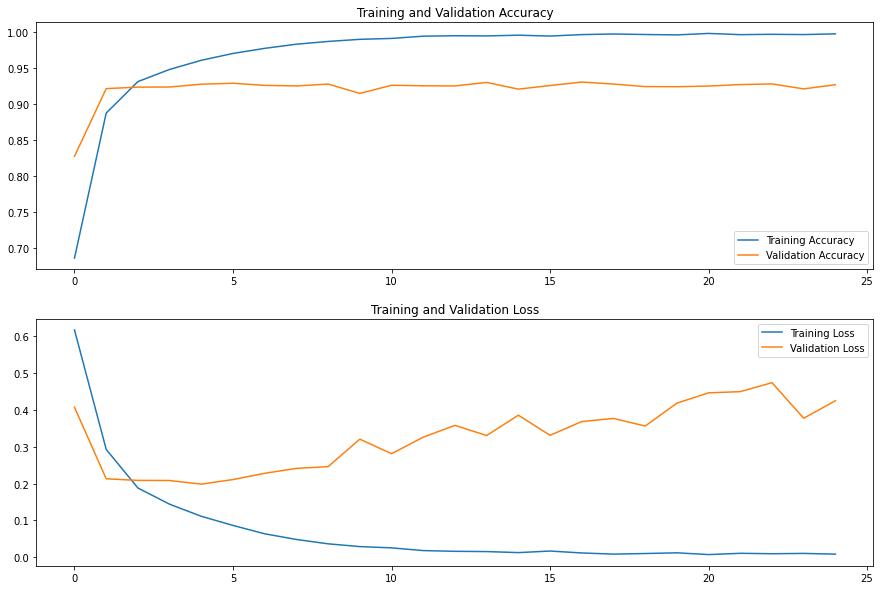

In [12]:
acc = [history_two_layers.history['accuracy'], history_two_layers.history['val_accuracy']]
loss = [history_two_layers.history['loss'],  history_two_layers.history['val_loss']]

plot_perf.plot_training(25, acc, loss)

The general results of such simple CNN are very good, 92.6% of accuracy on validation data is great taking into account simplicity of the model. Nevertheless it overfitted and should be trained on a lower number of epochs, what can be easily concluded from both plot and difference between training and validation accuracy. 

In [14]:
# save the trained neural network
#two_layers_cnn.save('trained_networks/two_layers.h5')

### Two Layers CNN with Image Augmentation 

Now let's apply this simple architecture to the augmented dataset.

In [14]:
two_layers_cnn_aug = TwoLayers(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
two_layers_cnn_aug.get_summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 115, 115, 16)      448       
_________________________________________________________________
activation_3 (Activation)    (None, 115, 115, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 57, 64)        9280      
_________________________________________________________________
activation_4 (Activation)    (None, 57, 57, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [15]:
optimizer = Adam(lr=0.001) 
two_layers_cnn_aug.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_two_layers_aug = two_layers_cnn_aug.train(training_data=aug_train, epochs=10, validation_data=aug_validation)

In [18]:
scores_train = two_layers_cnn_aug.evaluate(aug_train)
scores_val = two_layers_cnn_aug.evaluate(aug_validation)

42/42 [==============================] - 19s 457ms/step - loss: 0.2123 - accuracy: 0.9189


In [19]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.2209
Training Accuracy: 92.43%
Validation Binary Crossentropy (Loss): 0.2123
Validation Accuracy: 91.89%


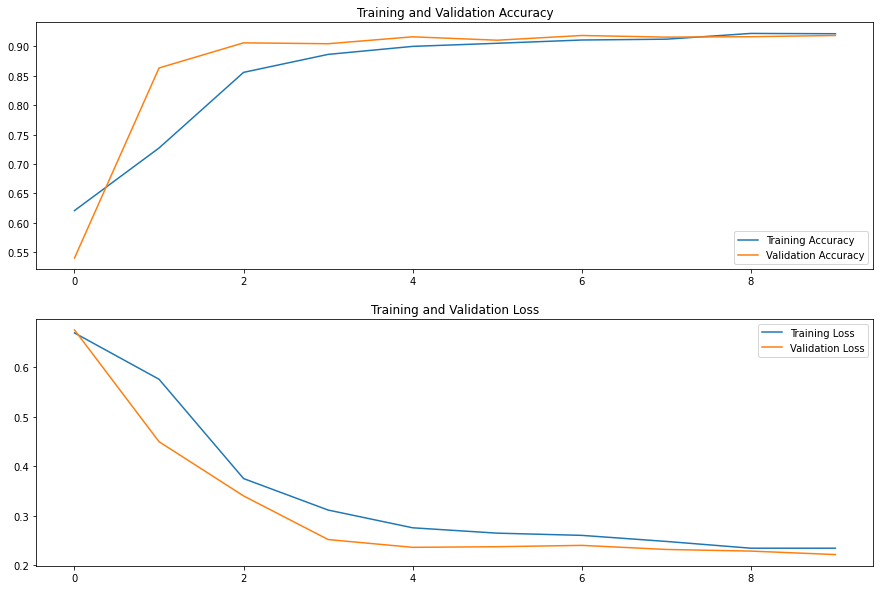

In [22]:
acc = [history_two_layers_aug.history['accuracy'], history_two_layers_aug.history['val_accuracy']]
loss = [history_two_layers_aug.history['loss'],  history_two_layers_aug.history['val_loss']]

plot_perf.plot_training(10, acc, loss)

The validation accuracy decreased slightly, but the difference might not be significant. What is more important is that the model did not overfit as it did in the previous training with data that was not augmented. 

*Comment*: Number of epochs was reduced becouse of two reasons. Firstly, previously it was too much and the model overfitted very fast. Secondly, training CNNs is overall quite time consuming.

In [17]:
# save the trained neural network
#two_layers_cnn_aug.save('trained_networks/two_layers_aug.h5')

<br>

## Three Layers CNN

The next model is not much different in terms of architecture from the previous one. The main change is adding a new convolutional layer. Let's now see if it improves the performance. 

In [9]:
three_layers_cnn = ThreeLayers(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
three_layers_cnn.get_summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 115, 115, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 115, 115, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 57, 57, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)       

In [24]:
optimizer = Adam(lr=0.001) 
three_layers_cnn.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_three_layers = three_layers_cnn.train(training_data=train, epochs=25, validation_data=validation) 

In [13]:
scores_train = three_layers_cnn.evaluate(train)
scores_val = three_layers_cnn.evaluate(validation)

42/42 [==============================] - 6s 139ms/step - loss: 0.4074 - accuracy: 0.9402


In [14]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.001
Training Accuracy: 99.98%
Validation Binary Crossentropy (Loss): 0.4074
Validation Accuracy: 94.02000000000001%


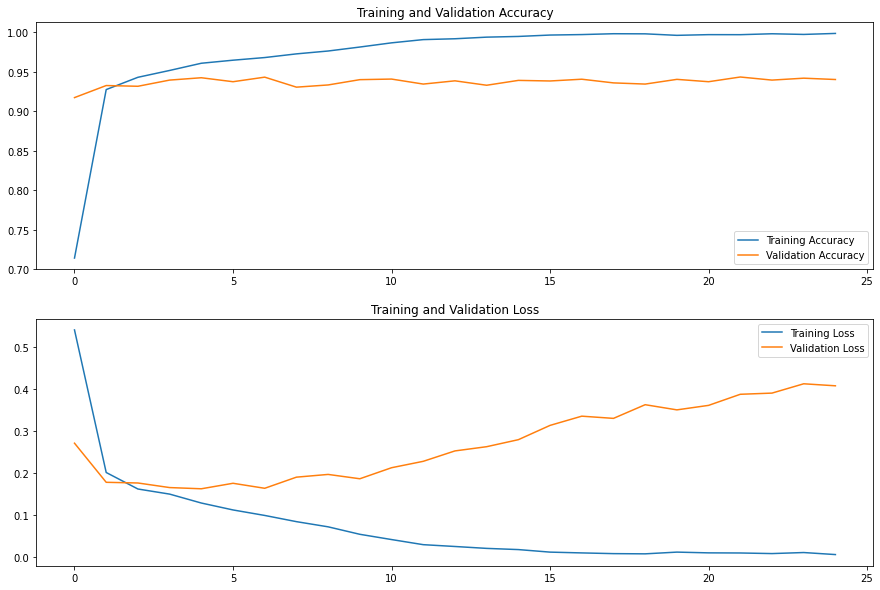

In [29]:
acc = [history_three_layers.history['accuracy'], history_three_layers.history['val_accuracy']]
loss = [history_three_layers.history['loss'],  history_three_layers.history['val_loss']]

plot_perf.plot_training(25, acc, loss)

Once again it's clear that 25 epochs is too much and the model overfits. Nevertheless the accuracy on validation dataset is very good - 94%. 

In [30]:
# save the trained neural network
#three_layers_cnn.save('trained_networks/three_layers.h5')

### Three Layers CNN with Image Augmentation

Similarly as before the model is recreated and trained once again with use of augmented data.

In [23]:
three_layers_cnn_aug = ThreeLayers(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
three_layers_cnn_aug.get_summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 115, 115, 16)      448       
_________________________________________________________________
activation_6 (Activation)    (None, 115, 115, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
activation_7 (Activation)    (None, 57, 57, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)       

In [24]:
optimizer = Adam(lr=0.001) 
three_layers_cnn_aug.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_three_layers_aug = three_layers_cnn_aug.train(training_data=aug_train, epochs=10, validation_data=aug_validation)

In [27]:
scores_train = three_layers_cnn_aug.evaluate(aug_train)
scores_val = three_layers_cnn_aug.evaluate(aug_validation)

42/42 [==============================] - 19s 455ms/step - loss: 0.1922 - accuracy: 0.9301


In [28]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.1834
Training Accuracy: 94.01%
Validation Binary Crossentropy (Loss): 0.1922
Validation Accuracy: 93.01%


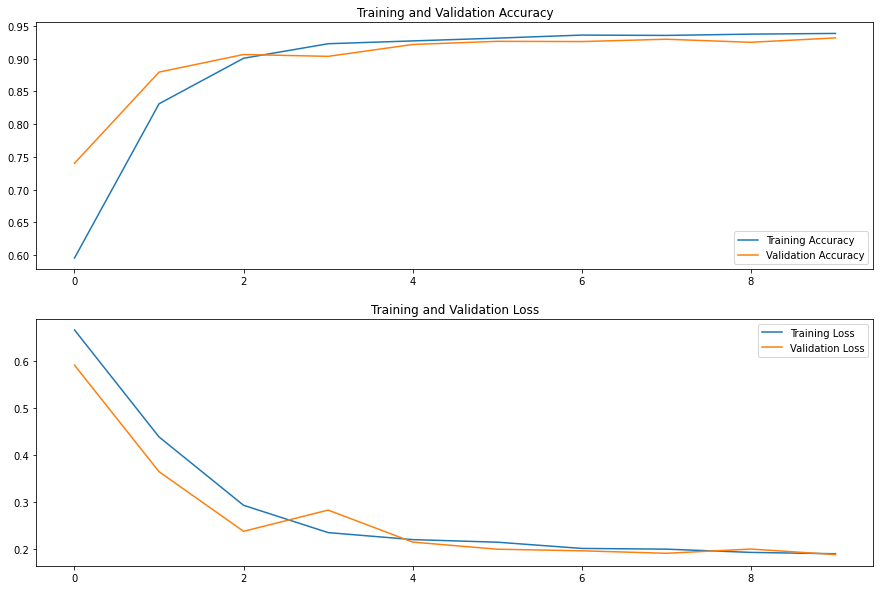

In [29]:
acc = [history_three_layers_aug.history['accuracy'], history_three_layers_aug.history['val_accuracy']]
loss = [history_three_layers_aug.history['loss'],  history_three_layers_aug.history['val_loss']]

plot_perf.plot_training(10, acc, loss)

The overall performance is again good and comparable to the model trained on the unchanged dataset. There is no overfitting detected, although the accruacy decreased slightly to 93%.

In [26]:
# save the trained neural network
#three_layers_cnn_aug.save('trained_networks/three_layers_cnn_aug.h5')

<br>

## LeNet5

LeNet5 is an architecture of CNN introduced by Yann LeCun: [LeNet on Wiki](https://en.wikipedia.org/wiki/LeNet). I took advanted of this architecture and chose some appropriate hyperparameters for this problem. 

In [31]:
lenet = LeNet5(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
lenet.get_summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 115, 115, 6)       168       
_________________________________________________________________
activation_4 (Activation)    (None, 115, 115, 6)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 57, 57, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 16)        880       
_________________________________________________________________
activation_5 (Activation)    (None, 57, 57, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 28, 28, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [32]:
optimizer = Adam(lr=0.001) 
lenet.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_lenet = lenet.train(training_data=train, epochs=25, validation_data=validation)

In [16]:
scores_train = lenet.evaluate(train)
scores_val = lenet.evaluate(validation)

42/42 [==============================] - 6s 138ms/step - loss: 0.4673 - accuracy: 0.9251


In [17]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.0035
Training Accuracy: 99.89%
Validation Binary Crossentropy (Loss): 0.4673
Validation Accuracy: 92.51%


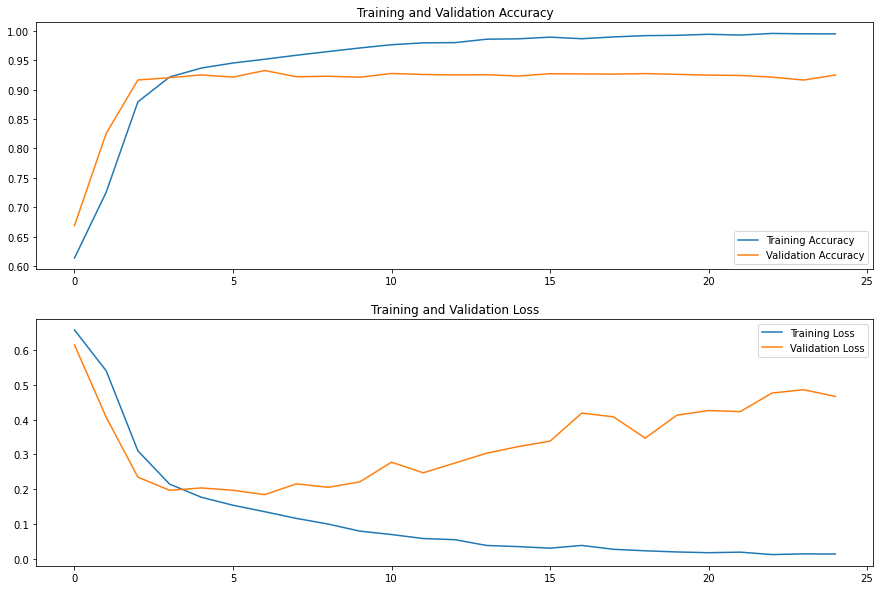

In [37]:
acc = [history_lenet.history['accuracy'], history_lenet.history['val_accuracy']]
loss = [history_lenet.history['loss'],  history_lenet.history['val_loss']]

plot_perf.plot_training(25, acc, loss)

Yet another example of too many training epochs leading to overfitting. Nevertheless the model performed well and its validation accuracy is comparable to all of the previous models - 92.5% is satisfactory.

In [38]:
# save the trained neural network
#lenet.save('trained_networks/lenet.h5')

### LeNet5 with Image Augmentation 

In [30]:
lenet_aug = LeNet5(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
lenet_aug.get_summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 115, 115, 6)       168       
_________________________________________________________________
activation_10 (Activation)   (None, 115, 115, 6)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 57, 57, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 57, 16)        880       
_________________________________________________________________
activation_11 (Activation)   (None, 57, 57, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 28, 28, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)            

In [31]:
optimizer = Adam(lr=0.001) 
lenet_aug.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_lenet_aug = lenet_aug.train(training_data=aug_train, epochs=10, validation_data=aug_validation)

In [34]:
scores_train = lenet_aug.evaluate(aug_train)
scores_val = lenet_aug.evaluate(aug_validation)

42/42 [==============================] - 18s 435ms/step - loss: 0.2279 - accuracy: 0.9206


In [35]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.1925
Training Accuracy: 93.72%
Validation Binary Crossentropy (Loss): 0.2279
Validation Accuracy: 92.06%


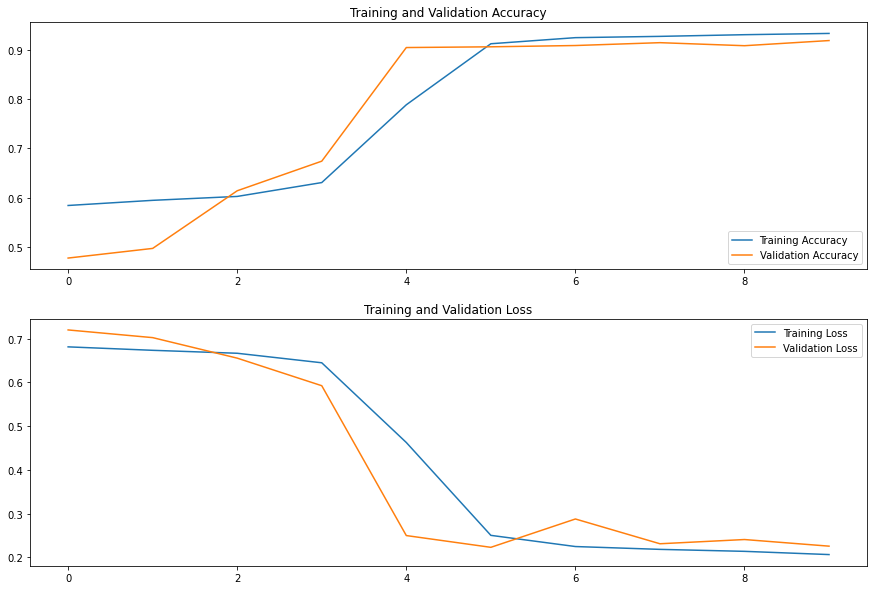

In [36]:
acc = [history_lenet_aug.history['accuracy'], history_lenet_aug.history['val_accuracy']]
loss = [history_lenet_aug.history['loss'],  history_lenet_aug.history['val_loss']]

plot_perf.plot_training(10, acc, loss)

The training plots seem quite strange, at least to me. Nevertheless reducing number of epochs along with using augmented images allowed to reduce overfitting while remaining a good accuracy score around 92%.  

In [49]:
# save the trained neural network
#lenet_aug.save('trained_networks/lenet_aug.h5')

<br>

## AlexNet

AlexNet is also one of popular CNN architectures and was introduced by Alex Krizhevsky: [AlexNet on Wiki](https://en.wikipedia.org/wiki/AlexNet). Once again I implemented this architecture and chose a set of hyperparameters that seem to be reasonable in this case.

In [39]:
alexnet = AlexNet(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
alexnet.get_summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 115, 115, 4)       112       
_________________________________________________________________
activation_9 (Activation)    (None, 115, 115, 4)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 58, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 58, 16)        592       
_________________________________________________________________
activation_10 (Activation)   (None, 58, 58, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)       

In [40]:
optimizer = Adam(lr=0.001) 
alexnet.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_alexnet = alexnet.train(training_data=train, epochs=25, validation_data=validation)

In [19]:
scores_train = alexnet.evaluate(train)
scores_val = alexnet.evaluate(validation)

42/42 [==============================] - 6s 144ms/step - loss: 0.5410 - accuracy: 0.9488


In [20]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.0006
Training Accuracy: 99.99%
Validation Binary Crossentropy (Loss): 0.541
Validation Accuracy: 94.88%


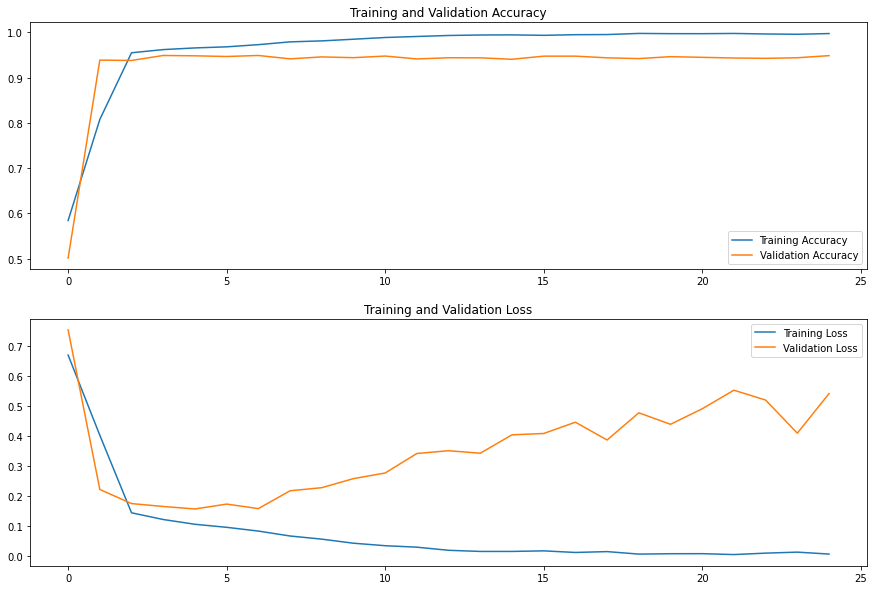

In [44]:
acc = [history_alexnet.history['accuracy'], history_alexnet.history['val_accuracy']]
loss = [history_alexnet.history['loss'],  history_alexnet.history['val_loss']]

plot_perf.plot_training(25, acc, loss)

The model outperformed previous models with validation accuracy slightly lower than 95%. Nevertheless the training process was conducted with too many epochs what lead to overfitting of the model.

In [45]:
# save the trained neural network
#alexnet.save('trained_networks/alexnet.h5')

### AlexNet with Image Augmentation 

In [37]:
alexnet_aug = AlexNet(input_shape=(115, 115, 3), activation='relu', dropout_rate=0.25)
alexnet_aug.get_summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 115, 115, 4)       112       
_________________________________________________________________
activation_15 (Activation)   (None, 115, 115, 4)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 58, 58, 4)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 58, 58, 16)        592       
_________________________________________________________________
activation_16 (Activation)   (None, 58, 58, 16)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 32)       

In [38]:
optimizer = Adam(lr=0.001) 
alexnet_aug.compile_model(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_alexnet_aug = alexnet_aug.train(training_data=aug_train, epochs=10, validation_data=aug_validation)

In [42]:
scores_train = alexnet_aug.evaluate(aug_train)
scores_val = alexnet_aug.evaluate(aug_validation)

42/42 [==============================] - 19s 450ms/step - loss: 0.1772 - accuracy: 0.9357


In [43]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.1761
Training Accuracy: 94.34%
Validation Binary Crossentropy (Loss): 0.1772
Validation Accuracy: 93.57%


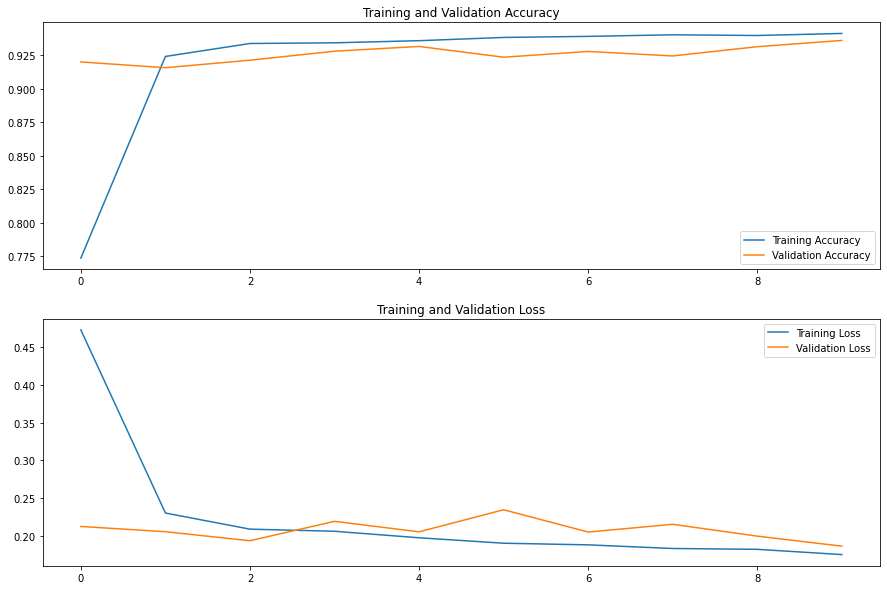

In [44]:
acc = [history_alexnet_aug.history['accuracy'], history_alexnet_aug.history['val_accuracy']]
loss = [history_alexnet_aug.history['loss'],  history_alexnet_aug.history['val_loss']]

plot_perf.plot_training(10, acc, loss)

Reducing number of epochs and using augmented data slightly decreased in-sample performance metrics of AlexNet, but it also reduced overfitting. Therefore AlexNet is still a very strong candidate to be the best model. 

In [41]:
# save the trained neural network
#alexnet_aug.save('trained_networks/alexnet_aug.h5')

<br>

<center> <font size=6> <b> Transfer Learning of CNNs </b> </font> </center>

This part of the project is devoted to transfer learning. I used two models available in the Keras package and fitted them to the unchanged dataset. Moreover I have also fine tuned the transfer models, that is unfroze a chosen number of top layers and re-trained their weights using the dataset of this project. Although transfer models are typically used for large scale applications and projects related to object recognition, I wanted to play around with them and check how much can be achieved in case of recoginition of simple images. Nevertheless it has to be said, that most of these models are just too complex and their architecture is just too complicated for such simple problem. 

## VGG-19

Below you can find architecture of both only base VGG-19 and the final transfer model.

In [9]:
vgg19 = VGG19(input_shape=(115, 115, 3))
vgg19.get_base_model_summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 115, 115, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 115, 115, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 115, 115, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 57, 57, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 57, 57, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 57, 57, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

In [14]:
vgg19.get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 115, 115, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4609      
Total params: 20,028,993
Trainable params: 4,609
Non-trainable params: 20,024,384
_________________________________________________________________


In [16]:
optimizer = Adam(lr=0.1)
vgg19.compile_model(optimizer=optimizer, loss=tf.losses.binary_crossentropy, metrics=['accuracy'])

Let's first check the accuracy without any training.

In [17]:
initial_scores = vgg19.evaluate(validation)

print(f'Initial Binary Crossentropy (Loss): {round(initial_scores[0], 4)}') 
print(f'Initial Accuracy: {str(round(initial_scores[1], 4) * 100) + "%"}')

42/42 [==============================] - 43s 1s/step - loss: 0.7031 - accuracy: 0.5035
Initial Binary Crossentropy (Loss): 0.7031
Initial Accuracy: 50.349999999999994%


Initial accuracy at the level of expected value of random assignments between two classes - 50%.

In [ ]:
history_vgg19 = vgg19.train(training_data=train, epochs=10, validation_data=validation)

In [20]:
scores_train = vgg19.evaluate(train)
scores_val = vgg19.evaluate(validation)

42/42 [==============================] - 46s 1s/step - loss: 0.8273 - accuracy: 0.9107


In [21]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 0.2897
Training Accuracy: 95.43%
Validation Binary Crossentropy (Loss): 0.8273
Validation Accuracy: 91.07%


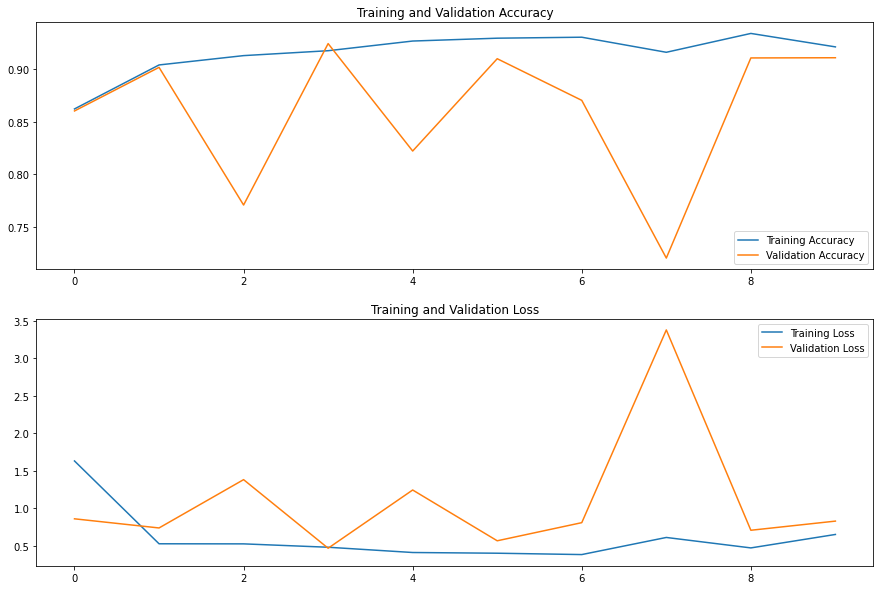

In [22]:
acc = [history_vgg19.history['accuracy'], history_vgg19.history['val_accuracy']]
loss = [history_vgg19.history['loss'],  history_vgg19.history['val_loss']]

plot_perf.plot_training(10, acc, loss)

Although the training path of the model is somehow weird and unstable, its overall performance is good. 10 epochs seem to enough to fit, but not overfit this transfer learning model. Validation accuracy of 91% is good, but below the scores achieved by simple models.

In [19]:
# save the trained model
#vgg19.save('trained_networks/vgg19.h5')

### Fine Tuning of VGG19

Let's check if fine tuning is able to improve VGG-19 performance and make this model better than the previously used much simpler CNNs.

In [11]:
print(f'Number of layers in the base model: {vgg19.number_of_layers_in_base_model()}')

Number of layers in the base model: 22


In [22]:
vgg19.unfreeze_top_layers(unfreeze_from=15)

In [23]:
optimizer_2 = Adam(lr=0.01)
vgg19.compile_model(optimizer=optimizer_2, loss=tf.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
history_fine_vgg = vgg19.fine_tuning(train, initial_epochs=10, fine_tune_epochs=10, validation_data=validation)

In [26]:
fine_scores_train = vgg19.evaluate(train)
fine_scores_val = vgg19.evaluate(validation)

42/42 [==============================] - 46s 1s/step - loss: 0.5599 - accuracy: 0.9029


In [27]:
print("After Fine Tuning:")
print(f'Training Binary Crossentropy (Loss): {round(fine_scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(fine_scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(fine_scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(fine_scores_val[1], 4) * 100) + "%"}')

After Fine Tuning:
Training Binary Crossentropy (Loss): 0.1543
Training Accuracy: 95.08%
Validation Binary Crossentropy (Loss): 0.5599
Validation Accuracy: 90.29%


In [43]:
acc[0] += history_fine_vgg.history['accuracy']
acc[1] += history_fine_vgg.history['val_accuracy']

loss[0] += history_fine_vgg.history['loss']
loss[1] += history_fine_vgg.history['val_loss']

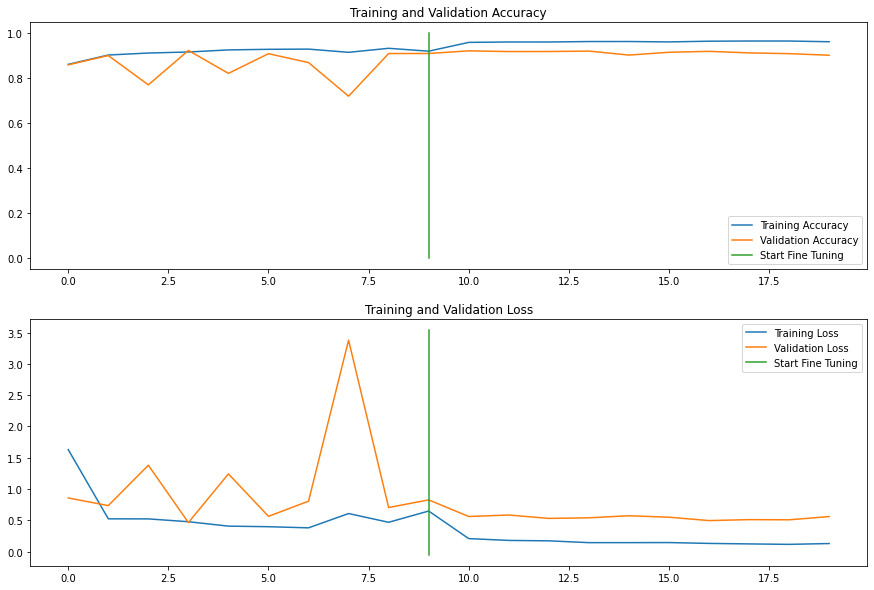

In [44]:
plot_perf.plot_fine_tuning(10, 10, acc, loss)

Fine tuning brought some stabilization in the process and loss metric did in fact decrease, but the overall performance decreased. Nevertheless validation performance around 90% is still not bad.

In [25]:
# Save the model again after fine tuning
#vgg19.save('trained_networks/vgg19_fine.h5')

## MobileNetV2

MobileNet is another transfer learning model available in the Keras package that can be used for image classification and recoginition. Its very complex structure is presented below.

In [ ]:
moblie_net = MobileNetV2(input_shape=(115, 115, 3), dropout_rate=0.25)
# moblie_net.get_base_model_summary() # this model has very, very large structure and I decided to hide it

In [11]:
moblie_net.get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 115, 115, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20480)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 20481     
Total params: 2,278,465
Trainable params: 20,481
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
optimizer = Adam(lr=0.1)
moblie_net.compile_model(optimizer=optimizer, loss=tf.losses.binary_crossentropy, metrics=['accuracy'])

In [14]:
initial_scores = moblie_net.evaluate(validation)

print(f'Initial Binary Crossentropy (Loss): {round(initial_scores[0], 4)}') 
print(f'Initial Accuracy: {str(round(initial_scores[1], 4) * 100) + "%"}')

42/42 [==============================] - 100s 2s/step - loss: 1.2893 - accuracy: 0.4474
Initial Binary Crossentropy (Loss): 1.2893
Initial Accuracy: 44.74%


Accuracy without training is below 50%.

In [ ]:
history_moblie_net = moblie_net.train(training_data=train, epochs=10, validation_data=validation)

In [17]:
scores_train = moblie_net.evaluate(train)
scores_val = moblie_net.evaluate(validation)

42/42 [==============================] - 11s 264ms/step - loss: 19.1621 - accuracy: 0.9309


In [18]:
print(f'Training Binary Crossentropy (Loss): {round(scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(scores_val[1], 4) * 100) + "%"}')

Training Binary Crossentropy (Loss): 2.305
Training Accuracy: 98.00999999999999%
Validation Binary Crossentropy (Loss): 19.1621
Validation Accuracy: 93.08999999999999%


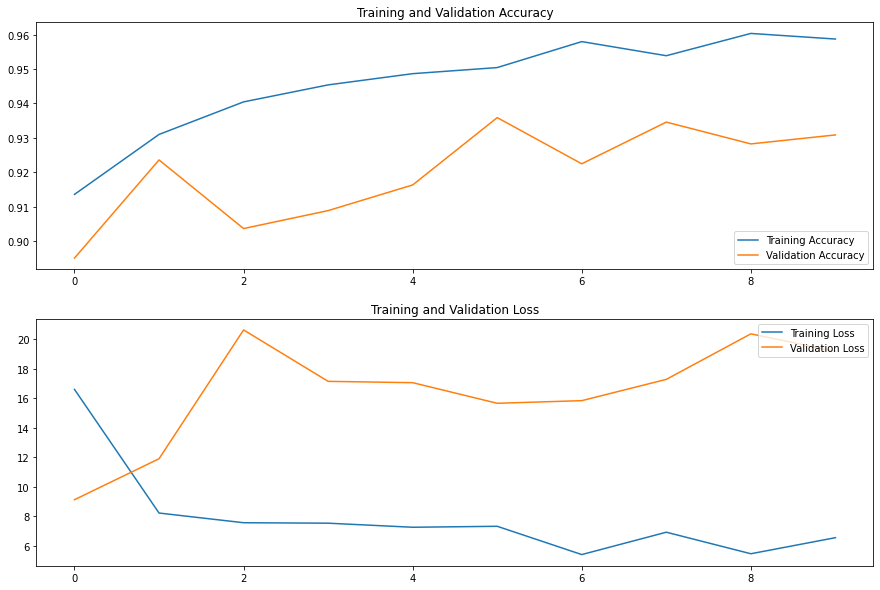

In [19]:
acc = [history_moblie_net.history['accuracy'], history_moblie_net.history['val_accuracy']]
loss = [history_moblie_net.history['loss'],  history_moblie_net.history['val_loss']]

plot_perf.plot_training(10, acc, loss)

I don't what happed to the loss metric - why are these values such high. Nevertheless the model performs quite good and is similar to the previous CNNs in terms of accuracy score.

In [16]:
# save the trained model
#moblie_net.save('trained_networks/moblie_net.h5')

### Fine Tuning of MobileNet

In [20]:
print(f'Number of layers in the base model: {moblie_net.number_of_layers_in_base_model()}')

Number of layers in the base model: 155


In [22]:
moblie_net.unfreeze_top_layers(unfreeze_from=120)

In [23]:
optimizer_2 = Adam(lr=0.01)
moblie_net.compile_model(optimizer=optimizer_2, loss=tf.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
history_fine_moblie_net = moblie_net.fine_tuning(train, initial_epochs=10, fine_tune_epochs=15, validation_data=validation)

In [26]:
fine_scores_train = moblie_net.evaluate(train)
fine_scores_val = moblie_net.evaluate(validation)

42/42 [==============================] - 11s 262ms/step - loss: 16.2483 - accuracy: 0.9337


In [30]:
print("After Fine Tuning:")
print(f'Training Binary Crossentropy (Loss): {round(fine_scores_train[0], 4)}')
print(f'Training Accuracy: {str(round(fine_scores_train[1], 4) * 100) + "%"}')
print(f'Validation Binary Crossentropy (Loss): {round(fine_scores_val[0], 4)}') 
print(f'Validation Accuracy: {str(round(fine_scores_val[1], 4) * 100) + "%"}')

After Fine Tuning:
Training Binary Crossentropy (Loss): 0.3262
Training Accuracy: 99.46000000000001%
Validation Binary Crossentropy (Loss): 16.2483
Validation Accuracy: 93.37%


In [28]:
acc[0] += history_fine_moblie_net.history['accuracy']
acc[1] += history_fine_moblie_net.history['val_accuracy']

loss[0] += history_fine_moblie_net.history['loss']
loss[1] += history_fine_moblie_net.history['val_loss']

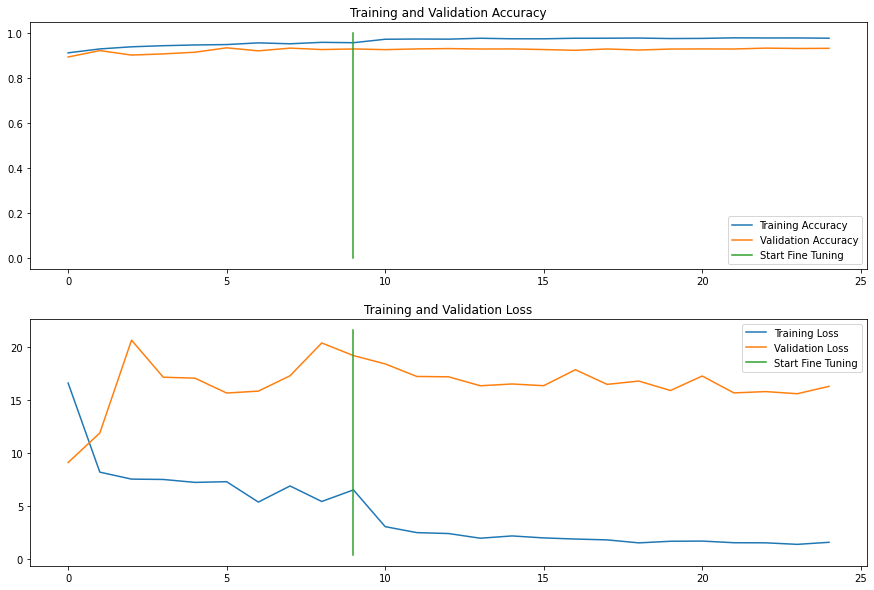

In [29]:
plot_perf.plot_fine_tuning(10, 15, acc, loss)

The fine tuning did not significantly improve the validation accuracy score, altough during the fine tuning the trainig loss decreased significanty. Nevertheless the model overfitted what could be observed from both plots and differenced between training and validation metrics.

In [25]:
# Save the model again after fine tuning
#moblie_net.save('trained_networks/moblie_net_fine.h5')

<br>

Below there are few cells connected with making/saving predictions and preparing summary data frame.

In [93]:
# preparations for results presentation
saved_models = os.listdir('trained_networks/')
names = [name.split('.')[0] for name in saved_models]

cnn_models = {}
for filename in saved_models:
    name = filename.split('.')[0]
    model = load_model('trained_networks/' + filename)
    cnn_models[name] = model

In [ ]:
acc_scores = {}

for name, model in cnn_models.items():
    train_acc = model.evaluate(train)[1]
    val_acc = model.evaluate(validation)[1]
    acc_scores[name] = {'Train': train_acc, "Validation": val_acc}

<br>
<br>

<center> <font size=6> <b> Summary </b> </font> </center>

The goal of this project was to come up with a machine learning model for detection of malaria based on photos of blood cells. For such purpose various convolutional neural networks were trained for classification of images into two groups: infected and healthy cells. Additionally data augmentation technique was used for training and compared with just plain images. Along with training of self implemented networks, I have also used transfer learning - VGG19 and MoblieNet from the Keras package. The table below contains summary of all models presented in this project - in sample and validation accuracy scores evaluated on the validation set of plain images.

In [100]:
display(pd.DataFrame(acc_scores).transpose().sort_values(by='Validation', ascending=False))

,Train,Validation
alexnet_aug,0.959005,0.949683
alexnet,0.999860,0.948751
three_layers_cnn_aug,0.955371,0.940552
three_layers,0.999814,0.940179
two_layers_aug,0.949036,0.935706
moblie_net_fine,0.994596,0.933656
moblie_net,0.980061,0.930861
lenet_aug,0.957235,0.929929
two_layers,0.999488,0.926575
lenet,0.998882,0.925084


The main conclusion from analysis of this table is that data augmentation does improve the process of training and positively influences model's performance. All models trained on augmented data resulted with better validation score (plain data) than the same models trained without data augmentation. Let's now see the results of three best models on a completly out-of-sample testing images. The chosen models are: AlexNet, Three Layers (both trained on augmented data) and MobileNet with fine tuning.  

In [111]:
names = ["alexnet_aug", "three_layers_cnn_aug", "moblie_net_fine"]
test_models = dict(filter(lambda i: i[0] in names, cnn_models.items()))

In [113]:
for name, model in test_models.items():
    acc = model.evaluate(test)[1]
    acc_scores[name].update({'Test': acc})

23/23 [==============================] - 1s 43ms/step - loss: 0.1717 - accuracy: 0.9490


The table below containes accuracy scores of three best models on the out-of-sample testing data.

In [118]:
test_acc = dict(filter(lambda i: i[0] in names, acc_scores.items()))
display(pd.DataFrame(test_acc).transpose().sort_values(by='Test', ascending=False))

,Train,Validation,Test
alexnet_aug,0.959005,0.949683,0.950413
moblie_net_fine,0.994596,0.933656,0.949036
three_layers_cnn_aug,0.955371,0.940552,0.949036


To sum up, the best model both in-sample and out-of-sample is AlexNet trained with augmented images. Nevertheless the remaining models preseneted quite similar results and all of them scored above 90% accuracy. Moreover simpler models turned out to be better in this project and probably for simple applications it's better to use a relatively uncomplicated CNN architectures.

<br>
<br>

### References

* Blood cells images: https://lhncbc.nlm.nih.gov/LHC-downloads/dataset.html 
* Machine Learning 2 course materials prepared by dr Paweł Sakowski
* Transfer Learning guide by Francois Chollet: https://keras.io/guides/transfer_learning/
* TensorFlow image classification guide: https://www.tensorflow.org/tutorials/images/classification
* Keras API documentation: https://keras.io/api/
* TensorFlow API documentation: https://www.tensorflow.org/api_docs/python/tf